# First Model Run(s)
This notebook runs initial models to get a benchmark of accuracy, etc. for understanding how well this method works as a first step. 

This file includes: 

## Imports and General Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score

from data_utils import *

In [2]:
# Class designed to give visual feedback as to how the NN training is going. 
# After each training cycle, keras will call the on_epoch_end() function here,
# which will make a plot showing the progress so far and display it on the screen.

import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.callbacks import Callback

class PlotLosses(Callback):
    def __init__(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        fig, axes = plt.subplots(1,2,figsize=(8,3))
        
        axes[0].plot(self.x, self.losses, label="Train loss")
        axes[0].plot(self.x, self.val_losses, label="Validation loss")
        axes[0].set_yscale('log')
        axes[0].set_xlabel('Number of epochs')
        axes[0].set_ylabel('Losses')
        axes[0].legend()
            
        axes[1].plot(self.x, self.acc, label="Train accuracy")
        axes[1].plot(self.x, self.val_acc, label="Validation accuracy")
        axes[1].set_xlabel('Number of epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()

2023-06-20 14:44:55.610922: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from sklearn.metrics import confusion_matrix

def plotConfMatrix(fig, ax, y_test, y_pred_binary):
    """
    Function plots confusion matrix, given yTest and yPred in BINARY forms
    """
    
    cm = confusion_matrix(y_test, y_pred_binary, normalize='true')
    # plot confusion matrix
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    fig.colorbar(im, ax=ax, shrink=0.82).set_label('Percentage', rotation=270, labelpad=15)

    classes = [0,1]
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    for i in range(len(classes)):
        for j in range(len(classes)):
            text = ax.text(j, i, format(cm[i, j], '.2%'),
                           ha="center", va="center",
                           color="white" if cm[i, j] > 0.5 else "black")

    plt.show()

In [4]:
from sklearn.metrics import roc_curve, auc

def plot_roc(fig, ax, y_pred, X_test, Y_test):
    """Plot the ROC curve for the given trained neural net using the given validation data.
    """
    y_probs = y_pred
    fpr, tpr, thresholds = roc_curve(Y_test, y_probs, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    ax.legend(loc="lower right")
    fig.tight_layout()

## 1. Data Prepping
Read in normalised images; create randomly cropped array; horizontally stack images

Note: This file horizontally stacks images to replicate method in Acero-Cuellar+ (2022); they note that it generally makes no significant difference to the results, BUT it does lose some spatial and geometrical information (which I'm a little unclear about!)

After running these cells, we are left with:
    - data: the horizontally stacked image data in the shape (numImages, 51, 153)
    - cropData: the horizontally stacked cropped images, of shape (numImages, cropSize, 3 * cropSize)
    - labelArray: target IDs and label, of the form (numImages, 2); order matches data and cropData

In [5]:
#read in files; these are the NORMALIZED images (change filenames as needed)

stampFile = 'stamp8imageArray.h5'
labelFile = 'stamp8labels.pk'

with h5py.File(stampFile, 'r') as f:
    imageArray = f['stamps'][:]

with open(labelFile, 'rb') as f:
    labelArray = pickle.load(f)

In [6]:
print(imageArray.shape)
print(labelArray.shape)

(89436, 51, 51, 3)
(89436, 2)


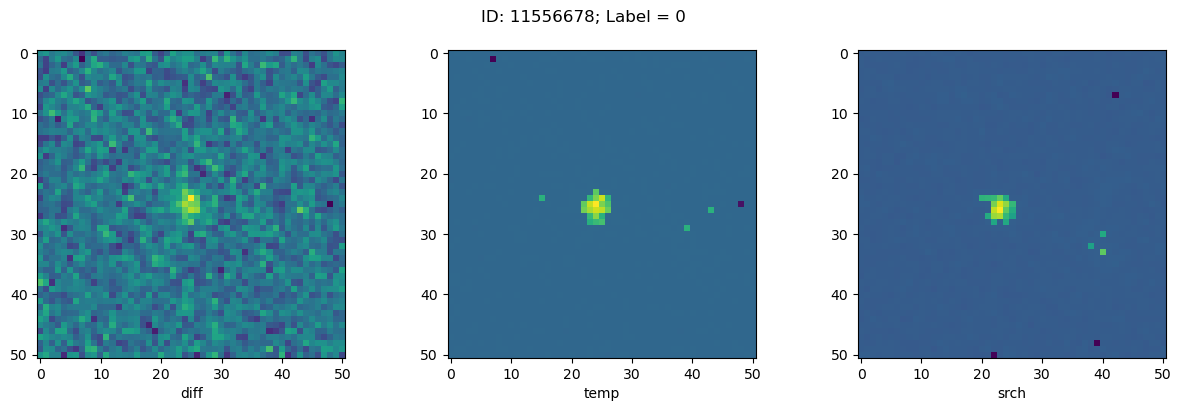

In [7]:
#visual check, make sure all is well :)

testnum = 19246
testimg = imageArray[testnum]
testlabel = labelArray[testnum]

fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].imshow(testimg[:,:,0])
axes[0].set_xlabel('diff')
axes[1].imshow(testimg[:,:,1])
axes[1].set_xlabel('temp')
axes[2].imshow(testimg[:,:,2])
axes[2].set_xlabel('srch')

fig.suptitle(f"ID: {testlabel[0]}; Label = {testlabel[1]}")
plt.show()

In [11]:
cropshape = (25,25)
centreCroppedArray = np.zeros((imageArray.shape[0], cropshape[0], cropshape[1], imageArray.shape[3]))
for i, triplet in enumerate(tqdm.tqdm(imageArray)):
    centreCroppedArray[i] = centredCrop(triplet)

100%|██████████| 89436/89436 [00:01<00:00, 86871.17it/s]


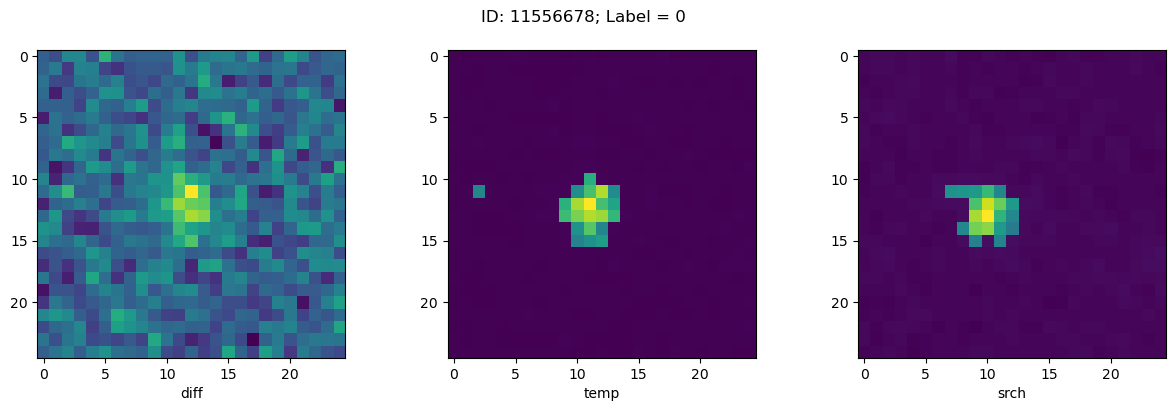

In [12]:
#visual check again

testcrop = centreCroppedArray[testnum]

fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].imshow(testcrop[:,:,0])
axes[0].set_xlabel('diff')
axes[1].imshow(testcrop[:,:,1])
axes[1].set_xlabel('temp')
axes[2].imshow(testcrop[:,:,2])
axes[2].set_xlabel('srch')

fig.suptitle(f"ID: {testlabel[0]}; Label = {testlabel[1]}")
plt.show()

In [13]:
randomCroppedArray = np.zeros((imageArray.shape[0], cropshape[0], cropshape[1], imageArray.shape[3]))
for i, triplet in enumerate(tqdm.tqdm(imageArray)):
    randomCroppedArray[i] = randomCrop(triplet)

100%|██████████| 89436/89436 [00:03<00:00, 24772.30it/s]


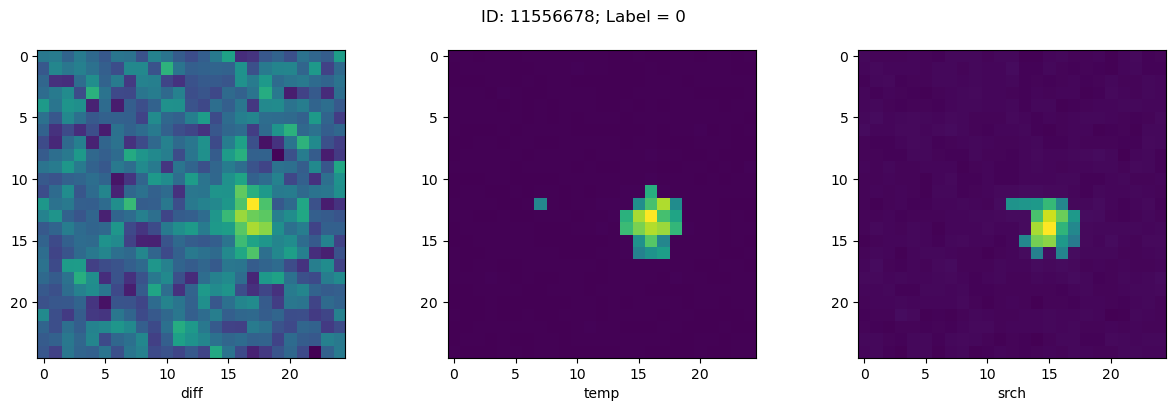

In [14]:
#visual check again

testcrop = randomCroppedArray[testnum]

fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].imshow(testcrop[:,:,0])
axes[0].set_xlabel('diff')
axes[1].imshow(testcrop[:,:,1])
axes[1].set_xlabel('temp')
axes[2].imshow(testcrop[:,:,2])
axes[2].set_xlabel('srch')

fig.suptitle(f"ID: {testlabel[0]}; Label = {testlabel[1]}")
plt.show()

100%|██████████| 89436/89436 [00:04<00:00, 19809.22it/s]


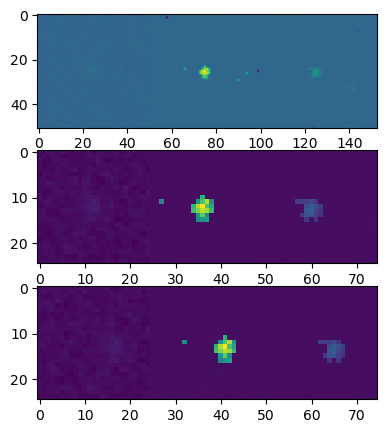

In [16]:
#and finally, horizontally stack!
data = np.zeros((imageArray.shape[0], imageArray.shape[1], imageArray.shape[2]*imageArray.shape[3]))
centreCropData = np.zeros((centreCroppedArray.shape[0], centreCroppedArray.shape[1], 
                           centreCroppedArray.shape[2]*centreCroppedArray.shape[3]))
randomCropData = np.zeros((randomCroppedArray.shape[0], randomCroppedArray.shape[1], 
                           randomCroppedArray.shape[2]*randomCroppedArray.shape[3]))

for i in tqdm.tqdm(range(len(data))):
    data[i] = hstackImages(imageArray[i])
    centreCropData[i] = hstackImages(centreCroppedArray[i])
    randomCropData[i] = hstackImages(randomCroppedArray[i])

fig, axes = plt.subplots(3, 1, figsize=(15,5))

axes[0].imshow(data[testnum])
axes[1].imshow(centreCropData[testnum])
axes[2].imshow(randomCropData[testnum])

When we plot these triplets horizontally, it looks visually like the difference image has disappeared; but looking at the pixel values in the array, they stay the same, so we can assume that it's a case of those pixel values being 'drowned out' by the more extreme values of the srch and temp images. (especially given that they are normalised differently: the diff images with mean = 0, std = 1, while temp and srch are scaled 0-->1 within 3sig boundary).

## 2. Running Different Benchmark Architectures
These subsections train different models based on architectures from previous papers, and records their results.

### Splitting data, etc. 

In [8]:
from keras import layers, models, backend
from tensorflow.keras.optimizers import Adam, SGD
from keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split

Splitting data into train (70%), validation (10%), and test (20%) sets:

In [18]:
print(data.shape)
print(centreCropData.shape)
print(randomCropData.shape)

(89436, 51, 153)
(89436, 25, 75)
(89436, 25, 75)


In [19]:
data = data.reshape(data.shape[0], data.shape[1], data.shape[2], 1)
centreCropData = centreCropData.reshape(centreCropData.shape[0], centreCropData.shape[1], 
                                        centreCropData.shape[2], 1)
randomCropData = randomCropData.reshape(randomCropData.shape[0], randomCropData.shape[1], 
                                        randomCropData.shape[2], 1)

In [21]:
labels = labelArray[:,1].astype(float)

X_train, X_nontrain, y_train, y_nontrain = train_test_split(data, labels, train_size = 0.7)
X_test, X_valid, y_test, y_valid = train_test_split(X_nontrain, y_nontrain, train_size = 2/3)

#confirm splitting is correct
assert len(y_train)+len(y_valid)+len(y_test) == len(labels)
assert np.isclose(len(y_test)/len(labels), 0.2, rtol=0.01) 
assert np.isclose(len(y_valid)/len(labels), 0.1, rtol=0.01)

X_train_centre_crop, X_nontrain_centre_crop, y_train_centre_crop, y_nontrain_centre_crop = train_test_split(centreCropData, labels, train_size = 0.7)
X_test_centre_crop, X_valid_centre_crop, y_test_centre_crop, y_valid_centre_crop = train_test_split(X_nontrain_centre_crop, y_nontrain_centre_crop, train_size = 2/3)

#confirm splitting is correct
assert len(y_train_centre_crop)+len(y_valid_centre_crop)+len(y_test_centre_crop) == len(labels)
assert np.isclose(len(y_test_centre_crop)/len(labels), 0.2, rtol=0.01) 
assert np.isclose(len(y_valid_centre_crop)/len(labels), 0.1, rtol=0.01)

X_train_random_crop, X_nontrain_random_crop, y_train_random_crop, y_nontrain_random_crop = train_test_split(randomCropData, labels, train_size = 0.7)
X_test_random_crop, X_valid_random_crop, y_test_random_crop, y_valid_random_crop = train_test_split(X_nontrain_random_crop, y_nontrain_random_crop, train_size = 2/3)

#confirm splitting is correct
assert len(y_train_random_crop)+len(y_valid_random_crop)+len(y_test_random_crop) == len(labels)
assert np.isclose(len(y_test_random_crop)/len(labels), 0.2, rtol=0.01) 
assert np.isclose(len(y_valid_random_crop)/len(labels), 0.1, rtol=0.01)

### a. Acero-Cuellar Architecture: centred images
Using X_train, X_test, X_valid alongside y_train, y_test, y_valid

In [13]:
model = models.Sequential()

model.add(layers.Conv2D(16, (5,5), activation='relu', padding='valid', input_shape=(51, 153,1)))
model.add(layers.MaxPooling2D((2,2), strides = 2))
#paper says dropout here, but github code seems like there's none, so skipping for now!
model.add(layers.Conv2D(32, (5,5), activation='relu', padding='valid'))
model.add(layers.MaxPooling2D((2,2), strides = 2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (5,5), activation='relu', padding='valid'))
model.add(layers.MaxPooling2D((2,2), strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 47, 149, 16)       416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 70, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 35, 32)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 9, 35, 32)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 31, 64)         5

2023-06-17 09:34:56.643582: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 128. Tune using inter_op_parallelism_threads for best performance.


In [14]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

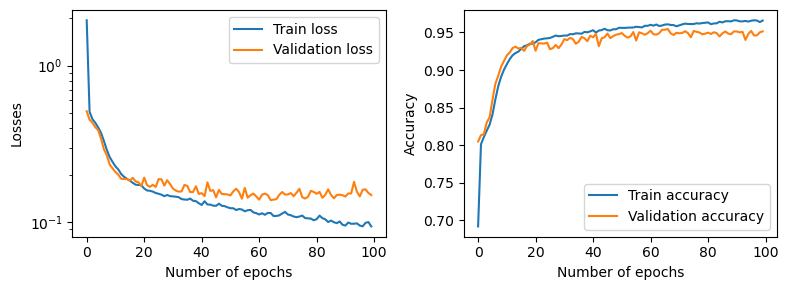

123/123 [==============================] - 68s 556ms/step - loss: 0.0942 - accuracy: 0.9658 - val_loss: 0.1493 - val_accuracy: 0.9515


In [15]:
saveFileName1 = 'model_benchmark_ACarchitecture_incldiff.keras'

if False: #change to if False once trained properly !
    
    plot_losses = PlotLosses()
    model.fit(X_train, y_train, 
              batch_size=512, epochs=100, 
              validation_data=(X_valid, y_valid), 
              verbose=1, callbacks=[plot_losses])
    
    model.save(saveFileName1)
    
model = load_model(saveFileName1)

### b. Acero-Cuellar Architecture: cropped images
Using X_train_random_crop, X_test_random_crop, X_valid_random_crop alongside y_train_random_crop, y_test_random_crop, y_valid_random_crop

In [16]:
backend.clear_session()

In [17]:
model2 = models.Sequential()

model2.add(layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(25,75,1)))
model2.add(layers.MaxPooling2D((2,2), strides = 2))
#paper says dropout here, but github code seems like there's none, so skipping for now!
model2.add(layers.Conv2D(32, (3,3), activation='relu', padding='valid'))
model2.add(layers.MaxPooling2D((2,2), strides = 2))
model2.add(layers.Dropout(0.3))
model2.add(layers.Conv2D(64, (3,3), activation='relu', padding='valid'))
model2.add(layers.MaxPooling2D((2,2), strides=2))
model2.add(layers.Dropout(0.3))

model2.add(layers.Flatten())
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 75, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 37, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 35, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 17, 32)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 17, 32)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 15, 64)         1

In [18]:
model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [19]:
X_valid_random_crop.shape

(8944, 25, 75, 1)

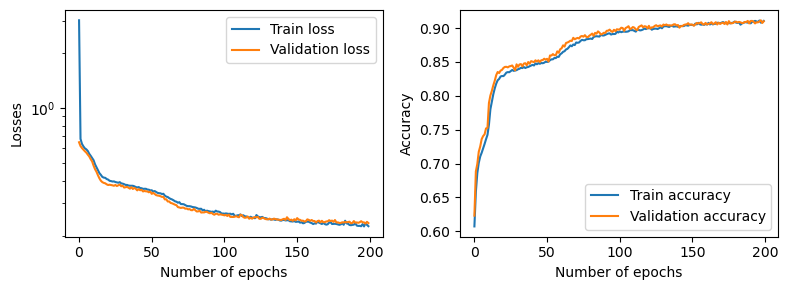

123/123 [==============================] - 15s 118ms/step - loss: 0.2251 - accuracy: 0.9105 - val_loss: 0.2341 - val_accuracy: 0.9100


In [20]:
saveFileName2 = 'model_benchmark_ACarchitecture_nodiff.keras'

if False: #change to if False once trained properly !
    
    plot_losses = PlotLosses()
    model2.fit(X_train_random_crop, y_train_random_crop, 
               batch_size=512, epochs=200, 
               validation_data=(X_valid_random_crop, y_valid_random_crop), 
               verbose=1, callbacks=[plot_losses])
    
    model2.save(saveFileName2)
    
model2 = load_model(saveFileName2)

### c. Acero-Cuellar Architecture: search temp input only, cropped images
Using X_train_random_crop, X_test_random_crop, X_valid_random_crop alongside y_train_random_crop, y_test_random_crop, y_valid_random_crop, notably indexed at [:, :, 25:] (to only include right two thirds, e.g. temp and srch images)

In [21]:
backend.clear_session()

In [22]:
model3 = models.Sequential()

model3.add(layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(25,50,1)))
model3.add(layers.MaxPooling2D((2,2), strides = 2))
#paper says dropout here, but github code seems like there's none, so skipping for now!
model3.add(layers.Conv2D(32, (3,3), activation='relu', padding='valid'))
model3.add(layers.MaxPooling2D((2,2), strides = 2))
model3.add(layers.Dropout(0.3))
model3.add(layers.Conv2D(64, (3,3), activation='relu', padding='valid'))
model3.add(layers.MaxPooling2D((2,2), strides=2))
model3.add(layers.Dropout(0.3))

model3.add(layers.Flatten())
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 50, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 25, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 23, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 11, 32)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 11, 32)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 9, 64)          1

In [23]:
model3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [27]:
print(X_valid_random_crop[:,:,25:].shape)
print(y_train_random_crop.shape)

(8944, 25, 50, 1)
(62605,)


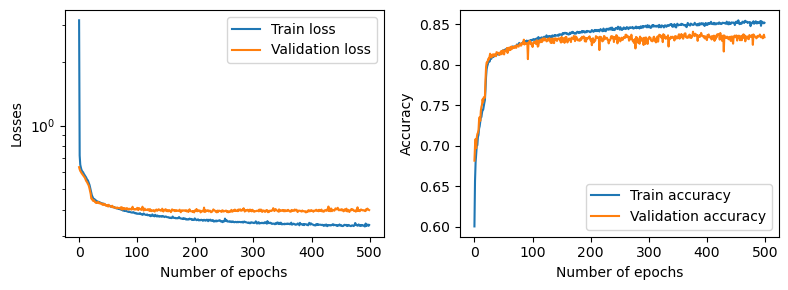

123/123 [==============================] - 10s 82ms/step - loss: 0.3379 - accuracy: 0.8519 - val_loss: 0.3979 - val_accuracy: 0.8341


In [28]:
saveFileName3 = 'model_benchmark_ACarchitecture_crop_nodiff.keras'

if False: #change to if False once trained properly !
    
    plot_losses = PlotLosses()
    model3.fit(X_train_random_crop[:,:,25:], y_train_random_crop, 
               batch_size=512, epochs=500, 
               validation_data=(X_valid_random_crop[:,:,25:], y_valid_random_crop), 
               verbose=1, callbacks=[plot_losses])
    
    model3.save(saveFileName3)
    
model3 = load_model(saveFileName3)

## 3. Testing Translation Invariance
Convnets are supposedly translation invariant, meaning that once they have been trained and have learnt a specific pattern, they can recognise it anywhere in the given field. 

This subsection examines how well this works for our given dataset, to consider whether it is worth (a) building a convenet that is *better* at recognising patterns that have been translated; and (b) building a convnet that also allows for rotational variance (e.g. a Group Equivariant Convnet, as per Cohen and Welling, https://arxiv.org/abs/1602.07576)

### a. Acero-Cuellar Architecture: search temp input only, (centred) cropped images
This test uses the same model as in section 2c, however it trains and validates on the CENTRED cropped images, before then running tests on the randomly cropped images to see how their accuracy rates compare. 

AFTER RUNNING:
Clearly, this model is *not* translationally invariant: a model trained on centred images, tested on images that *aren't* centred, has an accuracy of ~56% ; essentially not useful. 

**Questions**: would training the model for longer improve it's ability to recognise the same patterns, translated? (I don't know why it would...) Is there a feature of this specific architecture that doesn't allow for translational invariance? Does the fact that some of the features are partially cut off when I randomly crop mean that it's harder for the model to identify those patterns? (this makes sense; it might be worth trying with a different crop size, maybe 35x35? to reduce the # of targets that get cut off..)

**ANOTHER POSSIBLE ISSUE**: in the TAC+ paper, the saliency maps show that, once the diff image is removed, important pixels become located all around the image, not just around the centred source. It's possible that cropping the images actually removes some of that information... although I'm not fully convinced by this, since the model trained just on the cropped and centred images still does fine, until it is tested on images that aren't centred. Is it possible that the de-centred images lose information in their feature space that the original model is identifying (e.g. it uses the presence of features in both directions to differentiate bogus and real targets, and this relationship is lost when the target isn't centred anymore?) --> in any case, trying (as above) a larger crop size, to try and maintain more of the 'background', might be helpful... (but also: why not just train on the de-centred images, since it works? might be worth it to try this model, but in reverse: train on the de-centred images, and see if it then identifies the centred images easily...)

#### CHANGES AND RESULTS
1. retrained, increasing epochs from 200 to 500

- accuracy barely increases (90.03% --> 90.76%) for the cropped centred images
- interesting: testing on the randomly cropped images, the TP rate increases to ~67% (but TN goes to 47%, overall accuracy doesn't change)
- CONCLUSION: no consequential changes

2. using differently cropped images: 35x35 pixels to maintain more background info (section 3c and 3d)

- training on cropped images and then testing on centred cutouts works pretty much as expected; larger is perhaps slightly better then the 25x25, but not hugely (about 1-2%)

3. reverse the training to de-centred images, and then test on centred cutouts (section 3b)

- **this works very well!** in fact, testing on the centred cutouts has a higher accuracy rate (84%) than on the decentred cutouts (82%). 
- the lower percentage rate that the centred images, I think, is from things being cropped oddly (although... wouldn't these include more of the 'background' features and so still work well?)
- the real Q is: does this signify translational invariance? I don't really think so. Some of the randomly cropped images are definitely going to be centred, and so those features are being learned -- thus the all-centred test images are bound to be (largely) properly classified!
    - all this realy indicates is that it seems like training on images with spatial translations allows the CNN to recognise patterns that are spatially translated... which is just common sense. 

In [48]:
backend.clear_session()

In [49]:
model4 = models.Sequential()

model4.add(layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(25,50,1)))
model4.add(layers.MaxPooling2D((2,2), strides = 2))
#paper says dropout here, but github code seems like there's none, so skipping for now!
model4.add(layers.Conv2D(32, (3,3), activation='relu', padding='valid'))
model4.add(layers.MaxPooling2D((2,2), strides = 2))
model4.add(layers.Dropout(0.3))
model4.add(layers.Conv2D(64, (3,3), activation='relu', padding='valid'))
model4.add(layers.MaxPooling2D((2,2), strides=2))
model4.add(layers.Dropout(0.3))

model4.add(layers.Flatten())
model4.add(layers.Dense(32, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 50, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 25, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 23, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 11, 32)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 11, 32)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 9, 64)          1

In [50]:
model4.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [51]:
print(X_valid_centre_crop[:,:,25:].shape)
print(y_train_centre_crop.shape)

(8944, 25, 50, 1)
(62605,)


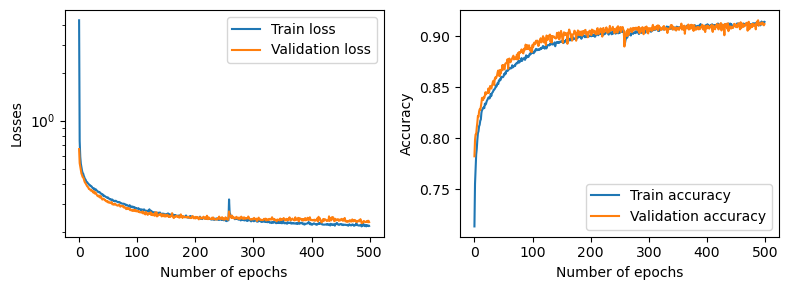

123/123 [==============================] - 10s 79ms/step - loss: 0.2177 - accuracy: 0.9140 - val_loss: 0.2302 - val_accuracy: 0.9119


In [52]:
saveFileName4 = 'model_benchmark_ACarchitecture_CENTREDcrop_nodiff.keras'

if False: #change to if False once trained properly !
    
    plot_losses = PlotLosses()
    model4.fit(X_train_centre_crop[:,:,25:], y_train_centre_crop, 
               batch_size=512, epochs=500,
               validation_data=(X_valid_centre_crop[:,:,25:], y_valid_centre_crop), 
               verbose=1, callbacks=[plot_losses])
    
    model4.save(saveFileName4)
    
model4 = load_model(saveFileName4)

#### Testing predictions here!

##### i. Testing against other cropped, centred images

559/559 [==============================] - 1s 2ms/step


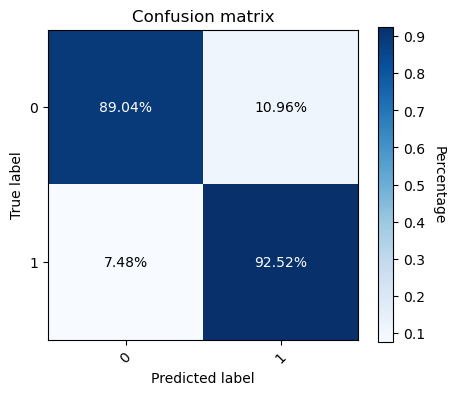

Accuracy: 90.76%
Precision: 89.22%
Recall: 92.52%


In [53]:
y_centre_pred = model4.predict(X_test_centre_crop[:,:,25:]).T[0]
y_centre_pred_binary = (y_centre_pred > 0.5).astype(int)

acc = accuracy_score(y_test_centre_crop, y_centre_pred_binary)
precision = precision_score(y_test_centre_crop, y_centre_pred_binary)
recall = recall_score(y_test_centre_crop, y_centre_pred_binary)

fig, ax = plt.subplots(figsize=(5,5))
plotConfMatrix(fig, ax, y_test_centre_crop, y_centre_pred_binary)

print(f'Accuracy: {acc*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')

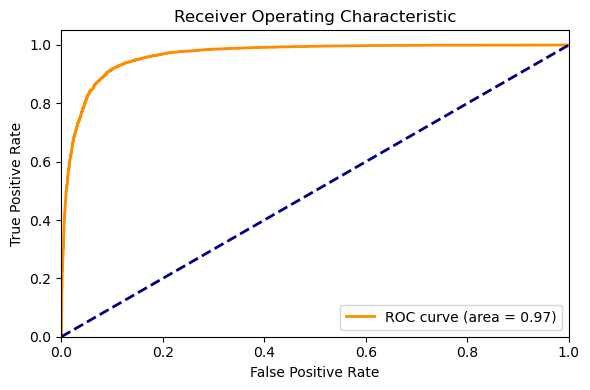

In [54]:
fig, ax = plt.subplots(figsize=(6,4))
plot_roc(fig, ax, y_centre_pred, X_test_centre_crop[:,:,25:], y_test_centre_crop)

##### ii. Testing against RANDOMLY cropped images!

559/559 [==============================] - 1s 2ms/step


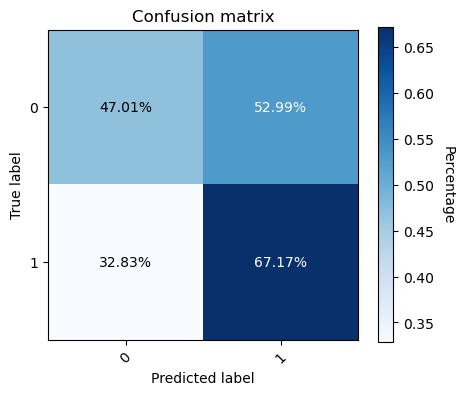

Accuracy: 57.02%
Precision: 55.57%
Recall: 67.17%


In [55]:
y_random_pred = model4.predict(X_test_random_crop[:,:,25:]).T[0]
y_random_pred_binary = (y_random_pred > 0.5).astype(int)

acc = accuracy_score(y_test_random_crop, y_random_pred_binary)
precision = precision_score(y_test_random_crop, y_random_pred_binary)
recall = recall_score(y_test_random_crop, y_random_pred_binary)

fig, ax = plt.subplots(figsize=(5,5))
plotConfMatrix(fig, ax, y_test_random_crop, y_random_pred_binary)

print(f'Accuracy: {acc*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')

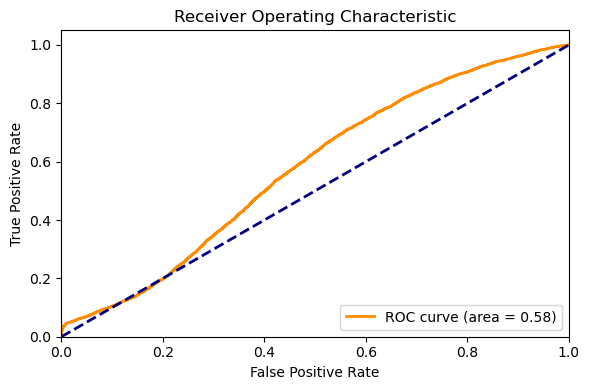

In [56]:
fig, ax = plt.subplots(figsize=(6,4))
plot_roc(fig, ax, y_random_pred, X_test_random_crop[:,:,25:], y_test_random_crop)

clearly, this particular model is NOT translation invariant in the patterns that it recognises... why?

### b. Acero-Cuellar Architecture: search temp input only, (random) cropped images with testing on (centred) cropped images (e.g. reverse of above!)

In [9]:
backend.clear_session()

In [10]:
model5 = models.Sequential()

model5.add(layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(25,50,1)))
model5.add(layers.MaxPooling2D((2,2), strides = 2))
#paper says dropout here, but github code seems like there's none, so skipping for now!
model5.add(layers.Conv2D(32, (3,3), activation='relu', padding='valid'))
model5.add(layers.MaxPooling2D((2,2), strides = 2))
model5.add(layers.Dropout(0.3))
model5.add(layers.Conv2D(64, (3,3), activation='relu', padding='valid'))
model5.add(layers.MaxPooling2D((2,2), strides=2))
model5.add(layers.Dropout(0.3))

model5.add(layers.Flatten())
model5.add(layers.Dense(32, activation='relu'))
model5.add(layers.Dense(1, activation='sigmoid'))

model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 50, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 25, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 23, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 11, 32)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 11, 32)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 9, 64)          1

2023-06-20 14:46:38.929086: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 128. Tune using inter_op_parallelism_threads for best performance.


In [11]:
print(X_valid_random_crop[:,:,25:].shape)
print(y_train_random_crop.shape)

NameError: name 'X_valid_random_crop' is not defined

In [60]:
model5.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

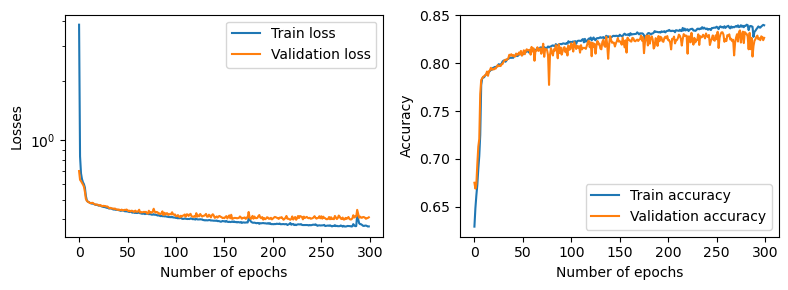

123/123 [==============================] - 10s 83ms/step - loss: 0.3681 - accuracy: 0.8398 - val_loss: 0.4092 - val_accuracy: 0.8266


In [61]:
saveFileName5 = 'model_benchmark_ACarchitecture_RANDOMcrop_nodiff.keras'

if False: #change to if False once trained properly !
    
    plot_losses = PlotLosses()
    model5.fit(X_train_random_crop[:,:,25:], y_train_random_crop, 
               batch_size=512, epochs=300,
               validation_data=(X_valid_random_crop[:,:,25:], y_valid_random_crop), 
               verbose=1, callbacks=[plot_losses])
    
    model5.save(saveFileName5)
    
model5 = load_model(saveFileName5)

Generally seems to have plateaued here (and train curve is starting to eviate more from validation curve), but future trial could probably try with greater num of epochs (although it's likely the accuracy won't improve by that much...)

#### Testing predictions here!

##### i. Testing against other cropped, non-centred (RANDOM CROPPED) images

559/559 [==============================] - 1s 2ms/step


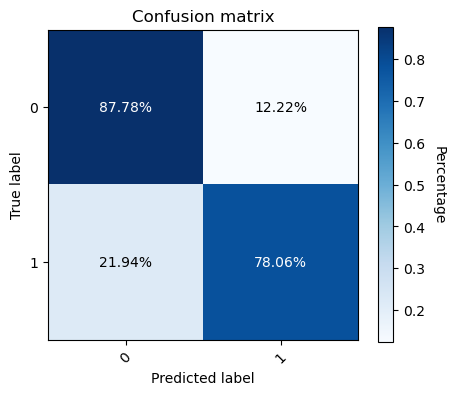

Accuracy: 82.95%
Precision: 86.31%
Recall: 78.06%


In [62]:
y_random_pred = model5.predict(X_test_random_crop[:,:,25:]).T[0]
y_random_pred_binary = (y_random_pred > 0.5).astype(int)

acc = accuracy_score(y_test_random_crop, y_random_pred_binary)
precision = precision_score(y_test_random_crop, y_random_pred_binary)
recall = recall_score(y_test_random_crop, y_random_pred_binary)

fig, ax = plt.subplots(figsize=(5,5))
plotConfMatrix(fig, ax, y_test_random_crop, y_random_pred_binary)

print(f'Accuracy: {acc*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')

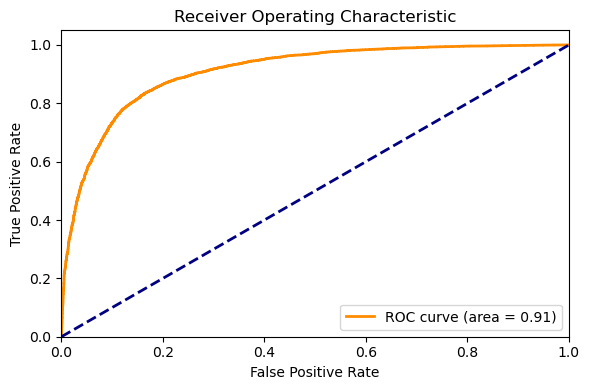

In [63]:
fig, ax = plt.subplots(figsize=(6,4))
plot_roc(fig, ax, y_random_pred, X_test_random_crop[:,:,25:], y_test_random_crop)

##### ii. Testing against cropped, CENTRED images

559/559 [==============================] - 1s 2ms/step


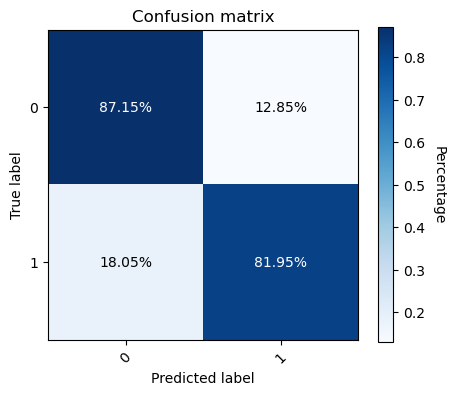

Accuracy: 84.58%
Precision: 86.22%
Recall: 81.95%


In [64]:
y_centre_pred = model5.predict(X_test_centre_crop[:,:,25:]).T[0]
y_centre_pred_binary = (y_centre_pred > 0.5).astype(int)

acc = accuracy_score(y_test_centre_crop, y_centre_pred_binary)
precision = precision_score(y_test_centre_crop, y_centre_pred_binary)
recall = recall_score(y_test_centre_crop, y_centre_pred_binary)

fig, ax = plt.subplots(figsize=(5,5))
plotConfMatrix(fig, ax, y_test_centre_crop, y_centre_pred_binary)

print(f'Accuracy: {acc*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')

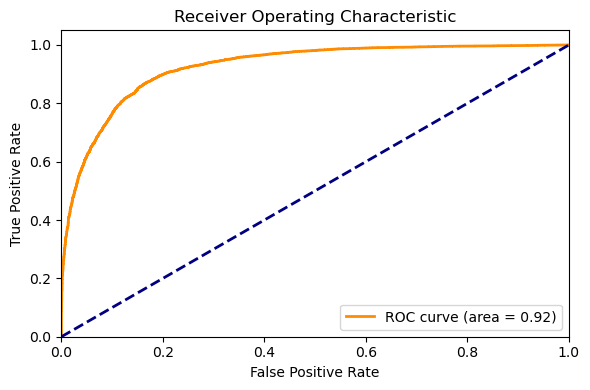

In [65]:
fig, ax = plt.subplots(figsize=(6,4))
plot_roc(fig, ax, y_centre_pred, X_test_centre_crop[:,:,25:], y_test_centre_crop)

### c. Acero-Cuellar Architecture: search temp input only, RANDOM cropped images, but larger cropped size (35x35 pixels) to include more background pixel info

##### Cropping images and splitting into test, training, validation

In [12]:
newcropshape = (35,35)
new_centreCroppedArray = np.zeros((imageArray.shape[0], newcropshape[0], newcropshape[1], imageArray.shape[3]))
new_randomCroppedArray = np.zeros((imageArray.shape[0], newcropshape[0], newcropshape[1], imageArray.shape[3]))

for i, triplet in enumerate(tqdm.tqdm(imageArray)):
    new_centreCroppedArray[i] = centredCrop(triplet, outputSize = newcropshape)
    new_randomCroppedArray[i] = randomCrop(triplet, outputSize = newcropshape)

100%|██████████| 89436/89436 [00:05<00:00, 16746.78it/s]


In [14]:
#horizontal stacking, and then split into test, train, validate

new_centreCropData = np.zeros((new_centreCroppedArray.shape[0], new_centreCroppedArray.shape[1], 
                               new_centreCroppedArray.shape[2]*new_centreCroppedArray.shape[3]))
new_randomCropData = np.zeros((new_randomCroppedArray.shape[0], new_randomCroppedArray.shape[1], 
                               new_randomCroppedArray.shape[2]*new_randomCroppedArray.shape[3]))

for i in tqdm.tqdm(range(len(new_centreCropData))):
    new_centreCropData[i] = hstackImages(new_centreCroppedArray[i])
    new_randomCropData[i] = hstackImages(new_randomCroppedArray[i])
    
new_centreCropData = new_centreCropData.reshape(new_centreCropData.shape[0], new_centreCropData.shape[1], 
                                                new_centreCropData.shape[2], 1)
new_randomCropData = new_randomCropData.reshape(new_randomCropData.shape[0], new_randomCropData.shape[1], 
                                                new_randomCropData.shape[2], 1)


labels = labelArray[:,1].astype(float)

new_X_train_centre_crop, new_X_nontrain_centre_crop, new_y_train_centre_crop, new_y_nontrain_centre_crop = train_test_split(new_centreCropData, labels, train_size = 0.7)
new_X_test_centre_crop, new_X_valid_centre_crop, new_y_test_centre_crop, new_y_valid_centre_crop = train_test_split(new_X_nontrain_centre_crop, new_y_nontrain_centre_crop, train_size = 2/3)

#confirm splitting is correct
assert len(new_y_train_centre_crop)+len(new_y_valid_centre_crop)+len(new_y_test_centre_crop) == len(labels)
assert np.isclose(len(new_y_test_centre_crop)/len(labels), 0.2, rtol=0.01) 
assert np.isclose(len(new_y_valid_centre_crop)/len(labels), 0.1, rtol=0.01)

new_X_train_random_crop, new_X_nontrain_random_crop, new_y_train_random_crop, new_y_nontrain_random_crop = train_test_split(new_randomCropData, labels, train_size = 0.7)
new_X_test_random_crop, new_X_valid_random_crop, new_y_test_random_crop, new_y_valid_random_crop = train_test_split(new_X_nontrain_random_crop, new_y_nontrain_random_crop, train_size = 2/3)

#confirm splitting is correct
assert len(new_y_train_random_crop)+len(new_y_valid_random_crop)+len(new_y_test_random_crop) == len(labels)
assert np.isclose(len(new_y_test_random_crop)/len(labels), 0.2, rtol=0.01) 
assert np.isclose(len(new_y_valid_random_crop)/len(labels), 0.1, rtol=0.01)

100%|██████████| 89436/89436 [00:02<00:00, 41095.51it/s]


##### Training model

In [15]:
backend.clear_session()

In [16]:
model6 = models.Sequential()

model6.add(layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(35,70,1)))
model6.add(layers.MaxPooling2D((2,2), strides = 2))
#paper says dropout here, but github code seems like there's none, so skipping for now!
model6.add(layers.Conv2D(32, (3,3), activation='relu', padding='valid'))
model6.add(layers.MaxPooling2D((2,2), strides = 2))
model6.add(layers.Dropout(0.3))
model6.add(layers.Conv2D(64, (3,3), activation='relu', padding='valid'))
model6.add(layers.MaxPooling2D((2,2), strides=2))
model6.add(layers.Dropout(0.3))

model6.add(layers.Flatten())
model6.add(layers.Dense(32, activation='relu'))
model6.add(layers.Dense(1, activation='sigmoid'))

model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 70, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 35, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 33, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 16, 32)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 16, 32)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 14, 64)         1

In [17]:
print(new_X_valid_random_crop[:,:,35:].shape)
print(new_y_train_random_crop.shape)

(8944, 35, 70, 1)
(62605,)


In [18]:
model6.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

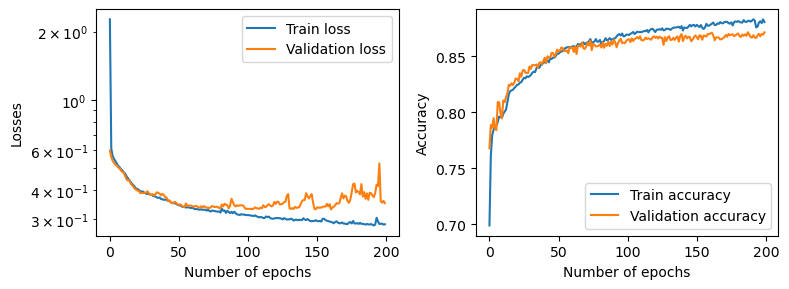

123/123 [==============================] - 18s 150ms/step - loss: 0.2837 - accuracy: 0.8804 - val_loss: 0.3515 - val_accuracy: 0.8712


In [19]:
saveFileName6 = 'model_benchmark_ACarchitecture_RANDOMcrop_35pixel_nodiff.keras'

if False: #change to if False once trained properly !
    
    plot_losses = PlotLosses()
    model6.fit(new_X_train_random_crop[:,:,35:], new_y_train_random_crop, 
               batch_size=512, epochs=200,
               validation_data=(new_X_valid_random_crop[:,:,35:], new_y_valid_random_crop), 
               verbose=1, callbacks=[plot_losses])
    
    model6.save(saveFileName6)
    
model6 = load_model(saveFileName6)

#### Testing

##### i. Testing against other cropped, non-centred (RANDOM CROPPED) images

559/559 [==============================] - 2s 3ms/step


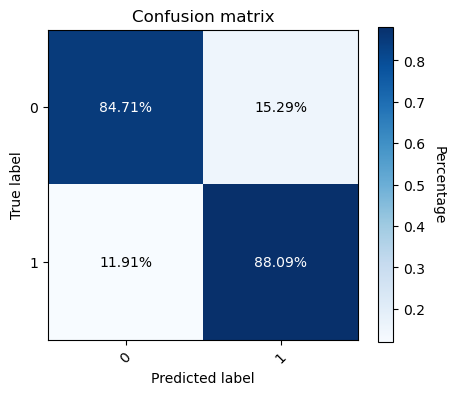

Accuracy: 86.40%
Precision: 85.22%
Recall: 88.09%


In [32]:
new_y_random_pred = model6.predict(new_X_test_random_crop[:,:,35:]).T[0]
new_y_random_pred_binary = (new_y_random_pred > 0.5).astype(int)

acc = accuracy_score(new_y_test_random_crop, new_y_random_pred_binary)
precision = precision_score(new_y_test_random_crop, new_y_random_pred_binary)
recall = recall_score(new_y_test_random_crop, new_y_random_pred_binary)

fig1, ax1 = plt.subplots(figsize=(5,5))

plotConfMatrix(fig1, ax1, new_y_test_random_crop, new_y_random_pred_binary)

print(f'Accuracy: {acc*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')

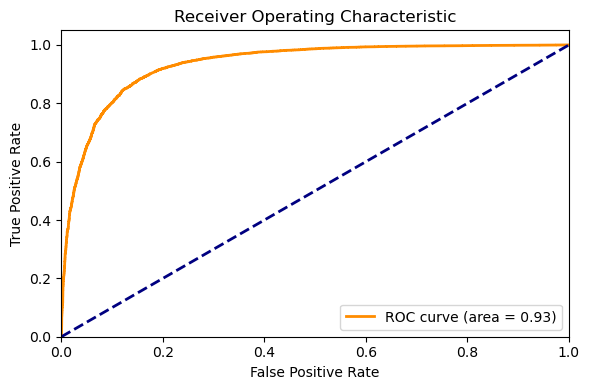

In [34]:
fig, ax = plt.subplots(figsize=(6,4))
plot_roc(fig, ax, new_y_random_pred, new_X_test_random_crop[:,:,35:], new_y_test_random_crop)

##### ii. Testing against CENTRED images

559/559 [==============================] - 2s 3ms/step


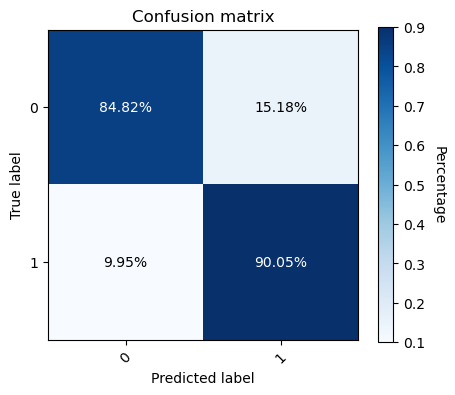

Accuracy: 87.44%
Precision: 85.61%
Recall: 90.05%


In [35]:
new_y_centre_pred = model6.predict(new_X_test_centre_crop[:,:,35:]).T[0]
new_y_centre_pred_binary = (new_y_centre_pred > 0.5).astype(int)

acc = accuracy_score(new_y_test_centre_crop, new_y_centre_pred_binary)
precision = precision_score(new_y_test_centre_crop, new_y_centre_pred_binary)
recall = recall_score(new_y_test_centre_crop, new_y_centre_pred_binary)

fig1, ax1 = plt.subplots(figsize=(5,5))

plotConfMatrix(fig1, ax1, new_y_test_centre_crop, new_y_centre_pred_binary)

print(f'Accuracy: {acc*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')

### d. Acero-Cuellar Architecture: search temp input only, CENTRED cropped images, but larger cropped size (35x35 pixels) to include more background pixel info

In [36]:
backend.clear_session()

In [37]:
model7 = models.Sequential()

model7.add(layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(35,70,1)))
model7.add(layers.MaxPooling2D((2,2), strides = 2))
#paper says dropout here, but github code seems like there's none, so skipping for now!
model7.add(layers.Conv2D(32, (3,3), activation='relu', padding='valid'))
model7.add(layers.MaxPooling2D((2,2), strides = 2))
model7.add(layers.Dropout(0.3))
model7.add(layers.Conv2D(64, (3,3), activation='relu', padding='valid'))
model7.add(layers.MaxPooling2D((2,2), strides=2))
model7.add(layers.Dropout(0.3))

model7.add(layers.Flatten())
model7.add(layers.Dense(32, activation='relu'))
model7.add(layers.Dense(1, activation='sigmoid'))

In [38]:
model7.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

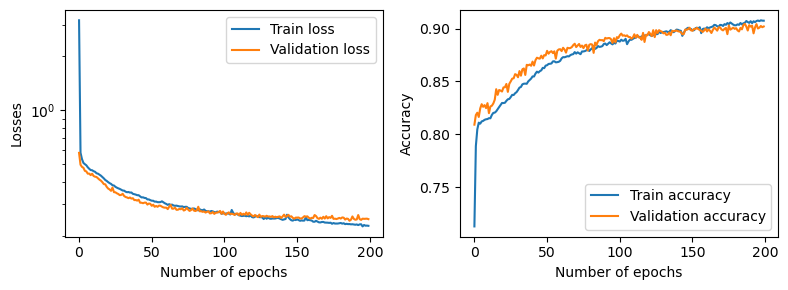

123/123 [==============================] - 19s 151ms/step - loss: 0.2270 - accuracy: 0.9074 - val_loss: 0.2474 - val_accuracy: 0.9019


In [40]:
saveFileName7 = 'model_benchmark_ACarchitecture_CENTREcrop_35pixel_nodiff.keras'

if False: #change to if False once trained properly !
    
    plot_losses = PlotLosses()
    model7.fit(new_X_train_centre_crop[:,:,35:], new_y_train_centre_crop, 
               batch_size=512, epochs=200,
               validation_data=(new_X_valid_centre_crop[:,:,35:], new_y_valid_centre_crop), 
               verbose=1, callbacks=[plot_losses])
    
    model7.save(saveFileName7)
    
model7 = load_model(saveFileName7)

#### Testing

##### ii. Testing against cropped, non-centred (RANDOM CROPPED) images

559/559 [==============================] - 2s 3ms/step


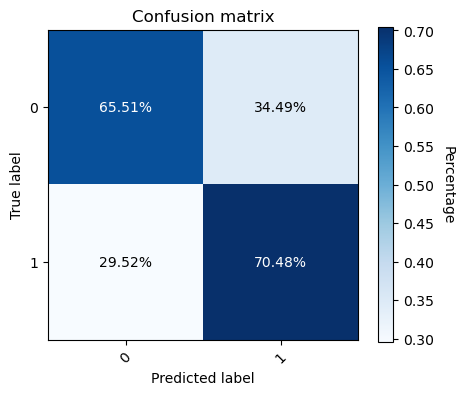

Accuracy: 68.00%
Precision: 67.15%
Recall: 70.48%


In [41]:
new_y_random_pred = model7.predict(new_X_test_random_crop[:,:,35:]).T[0]
new_y_random_pred_binary = (new_y_random_pred > 0.5).astype(int)

acc = accuracy_score(new_y_test_random_crop, new_y_random_pred_binary)
precision = precision_score(new_y_test_random_crop, new_y_random_pred_binary)
recall = recall_score(new_y_test_random_crop, new_y_random_pred_binary)

fig1, ax1 = plt.subplots(figsize=(5,5))

plotConfMatrix(fig1, ax1, new_y_test_random_crop, new_y_random_pred_binary)

print(f'Accuracy: {acc*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')

So it still seems like it doesn't work! The patterns are not translationally invariant, in that even including bigger sections of the image doesn't fully solve the issue (although it does improve it by ~10%, I think it's reasonable to assume that this is just due to the increased amount of information available, as well as the fact that it's likely more of the images are 'virtually' centred...)